<h1>Derivative Illustration</h1>
<p>This notebook gives an interactive illustration of a function's derivative.  In addition to an interactive graph which shows a function's derivative, this notebook is an example of using interacive widgets.  Some good resources I used in developing this are:
<ul>
<li>A blog post on <a href=https://blog.dominodatalab.com/interactive-dashboards-in-jupyter/>Building Interactive Dashboards with Jupyter</a></li>
<li>The <a href=https://github.com/ipython/ipywidgets>ipywidgets</a> documentation on <a href=https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html>Using Interact</a></li>
<li>A <a href=http://earthpy.org/pyncview_pm.html>good description</a> of using interact for data analysis.</li>
</ul>
In a future notebook, we will explore <a href=https://github.com/jupyter-incubator/dashboards>Jupyter Dashboards</a> as well which would help the layout of the interactive graph.
</p>
<h2>Initialization</h2>
<p>Below are the imports for the notebook.  Note that we are setting the matplotlib backend to 'notebook' with the <code>%matplotlib notebook</code> magic function.  This is somewhat described in the <a href=http://ipython.readthedocs.io/en/stable/interactive/plotting.html>ipython plotting documentation</a>.  The derivative function is described in the <a href=https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.misc.derivative.html>scipy documentation</a></p>

In [1]:
import numpy as np
from scipy.misc import derivative

%matplotlib notebook
import matplotlib
from matplotlib import pyplot as plt

import ipywidgets
from ipywidgets import widgets
from IPython.display import display

<p>The code below defines three sliders which allow us to set the left margin, right margin and the point at which the derivative is calculated.  The <a href = https://github.com/ipython/ipywidgets/blob/master/ipywidgets/widgets/widget_box.py>box</a> is to implement a Flexbox for positioning the widgets.  The best description of the Flexbox protocall I have found is on w3schools <a href = http://www.w3schools.com/css/css3_flexbox.asp>page</a>.

In [5]:
left=0
right = 4*np.pi
NumSteps = 100

BoxWidth = "75%"
LRLayout=ipywidgets.Layout(width='50%')

point_widget = widgets.FloatSlider(min=left, max=right, step=(right-left)/NumSteps,
                                   value=(right-left)/2, description="Point",
                                   layout=ipywidgets.Layout(width='100%'))

left_widget  = widgets.FloatSlider(min=-10., max=5., step=.5, description="Left", value=left, layout=LRLayout)
right_widget = widgets.FloatSlider(min=6.,   max=20., step=.5, description="Right", value=right, layout=LRLayout)
LRWidget= ipywidgets.Box(children=[left_widget,right_widget],
                         layout=ipywidgets.Layout(display='flex',flex_flow="row",width='100%'))

DIBox=ipywidgets.Box(children=[LRWidget,point_widget],
                     layout=ipywidgets.Layout(display='flex', flex_flow='column', align_items = 'stregtch', width=BoxWidth))

<p>The code below adds functionality to the slider widgets.  The key to this process are the calls to widget's <code>observe</code> method such as <code>point_widget.observe(PointChange, names='value')</code>.  The <a http://traitlets.readthedocs.io/en/stable/api.html#traitlets.HasTraits.observe>observe method</a>. takes an event handler function name (<code>PointChange</code> in this case) which will be called when somthing about the widget changes.  For this:
<ul>
<li>The observe method is also described in the <a href=https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Events.html#Traitlet-events>ipywidgets documentation</a>.
<li>The <code>names=</code> keword argument takes a list of possible event names.  The handler function will only be called for widget traits included in the list passed through <code>names</code>.  A good way of determining the avaliable trait names is to print the change dictionary in the event handler as in:<code>
    point_widget.observe(PrintChanges)

    def PrintChanges(changes):
        print(changes)</code></li>
<li>If you need help with a python dictionary, checkout <a href = https://docs.python.org/3.6/tutorial/datastructures.html#dictionaries>Dictionaries</a> in the python tutorial.</li>
<li>The handler function (<code>PointChange</code> in this case) must accept one positional argument, the dictionary describing the change.  I did not use this information.  Since there is one event handler for all changes, this dictionary could be used to respond to different changes.  Also, the passed dictionary contains the old trait values if they are needed.</li>
</ul></p>

<IPython.core.display.Javascript object>


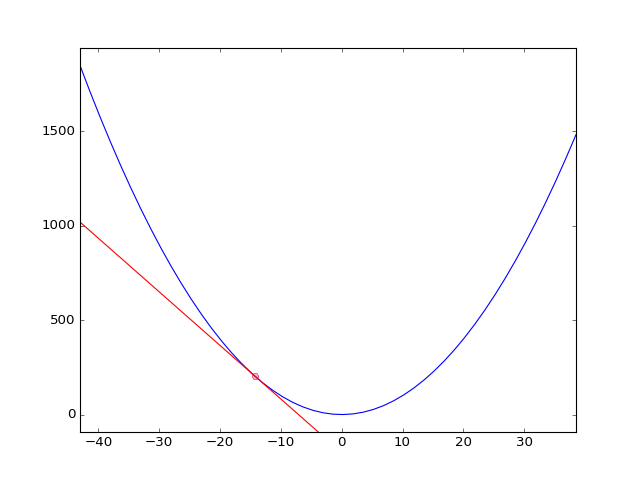

In [6]:
#Define the function which will be plotted.
def f(x):
    return x**2

VerAxisR = 1.1  #This sets the ratio of the y axis scale compared to the y data.

#Create the figure which will dispaly the function, the point of it and the derative.
MyFig, MyAxes = plt.subplots()
MyAxes.set_xlim(( left_widget.value, right))
MyAxes.set_ylim((-1, 1))
MyLineFunction, = MyAxes.plot([], [], label='Function f')
MyLinePoint,  = MyAxes.plot([], [], marker='H', ls='none', MFC=(1,0,0,.25),
                            mec=(1,0,0,1), label='Point')
MyLineDerivative, = MyAxes.plot([], [], label='Derivative')

#Set the function data to be plotted.
def Updatef(left,right):
    XFuntionValues = np.linspace(left,right)
    YFunctionValues = [f(x) for x in XFuntionValues]
    MyLineFunction.set_data(XFuntionValues,YFunctionValues)
    high=max(YFunctionValues)
    low =min(YFunctionValues)
    ave=(high+low)/2
    h=VerAxisR*(high - low)/2
    MyAxes.set_ylim((ave-h, ave+h))

#Plot the Point, calculate the derivative, and plot the slope sline
def UpdatePoint(x):
    MyLinePoint.set_data([x],[f(x)])
    m=derivative(f, x, order=5)
    b=f(x) - m*x
    MyLineDerivative.set_data([left_widget.value, right_widget.value],
                              [m*left_widget.value+b, m*right_widget.value+b])

#Sometimes we want to call update point with a value, not a change dictionary.
#The function below is the observe event handler. 
def PointChange(ChangeDict):
    UpdatePoint(point_widget.value)
    
#LRChange is called for both left and right changes.  We update the lines for the function and slope.
def LRChange(ChangeDict):
    Updatef(left_widget.value,right_widget.value)
    MyAxes.set_xlim(( left_widget.value, right_widget.value))
    UpdatePoint(point_widget.value)
    point_widget.step=(point_widget.max-point_widget.min)/NumSteps
    
#Adds dynamic behavior to the slide to allow the min and max values to change.
def LChange(ChangeDict):
    #check if the slideer is pushing against the outside edge
    if left_widget.value <= left_widget.min:
        #if it is, move the slider towards the outside.
        left_widget.min -= left_widget.step
        left_widget.max -= left_widget.step
    #check if the slidder is pushing against the inside edge
    #also make sure the slider is not pushing the other slider past the adjecent slider.
    if left_widget.value >= left_widget.max and left_widget.value < (right_widget.value - 2*left_widget.step):
        #move slider towards the middle.
        left_widget.max += left_widget.step
        left_widget.min += left_widget.step
        #check if we need to push the other slider as well.
        if left_widget.max > right_widget.min:
            right_widget.min += left_widget.step
            right_widget.max += left_widget.step
            #make sure the slider is between its min and max.  (This might be better as a call to RChange???)
            if right_widget.value < right_widget.min:
                right_widget.value = right_widget.min
    #Always check if we have moved figure edge past the derivative calculation point.
    if point_widget.value < left_widget.value:
        #if we have, set the point to the figure edge
        point_widget.value = left_widget.value
        UpdatePoint(point_widget.value)

    point_widget.min=left_widget.value
    LRChange(ChangeDict)    

def RChange(ChangeDict):
    #check if the slideer is pushing against the outside edge
    if right_widget.value >= right_widget.max:
        right_widget.max += right_widget.step
        right_widget.min += right_widget.step
    #check if the slidder is pushing against the inside edge
    #also make sure the slider is not pushing the other slider past the adjecent slider.
    if right_widget.value <= right_widget.min and right_widget.value > (left_widget.value + 2*right_widget.step):
        #move slider towards the middle.
        right_widget.min -= right_widget.step
        right_widget.max -= right_widget.step
        #check if we need to push the other slider as well.
        if right_widget.min < left_widget.max:
            left_widget.max -= right_widget.step
            left_widget.min -= right_widget.step
            #make sure the slider is between its min and max.  (This might be better as a call to RChange???)
            if left_widget.value > left_widget.max:
                left_widget.value = left_widget.min
    #Always check if we have moved figure edge past the derivative calculation point.
    if point_widget.value > right_widget.value:
        #if we have, set the point to the figure edge
        point_widget.value = right_widget.value
        UpdatePoint(point_widget.value)
    point_widget.max=right_widget.value
    LRChange(ChangeDict)    

point_widget.observe(PointChange, names='value')
left_widget.observe (LChange,    names='value')
right_widget.observe(RChange,    names='value')
UpdatePoint(point_widget.value)
Updatef(left_widget.value,right_widget.value)
display(DIBox)